In [1]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.svm import SVC

In [2]:
# helper function to plot curves
def make_plot(metric_values, train_values, cv_values, model_name, metric_name, score_name, curve_type):
    
    fig = plt.figure()
    ax = plt.gca()
    ax.plot(metric_values, train_values, label='Training score')
    ax.plot(metric_values, cv_values, label='CV score')
    ax.set_xlabel(metric_name)
    ax.set_ylabel(score_name)
    title = '{} curve for {} ({})'.format(curve_type, model_name, score_name)
    ax.set_title(title)
    ax.legend()
    
def plot_curve(model, model_name, X, y, param_name, scoring, curve_type, param_range=None):
    
    if curve_type == 'Validation':
        train_scores, cv_scores = validation_curve(model, X, y,
                                                   param_name=param_name, 
                                                   param_range=param_range, 
                                                   scoring=scoring,
                                                   cv=5,
                                                   n_jobs=-1)
    elif curve_type == 'Learning':
        train_sizes, train_scores, cv_scores = learning_curve(model, X, y,
                                                              train_sizes=np.linspace(.1, 1.0, 100),
                                                              scoring=scoring,
                                                              cv=5,
                                                              n_jobs=-1)
        param_range = train_sizes
        
    train_score_means = np.mean(train_scores, axis=1)
    cv_score_means = np.mean(cv_scores, axis=1)
    
    make_plot(metric_values=param_range,
              train_values=train_score_means,
              cv_values = cv_score_means,
              model_name=model_name, 
              metric_name=param_name.capitalize().replace('_',' '),
              score_name=scoring.capitalize(),
              curve_type=curve_type
             )

## Red & White Wine Dataset

In [3]:
df_white = pd.read_csv('winequality-white.csv', sep=';')
df_red = pd.read_csv('winequality-red.csv', sep=';')

df_white['type'] = ['white'] * len(df_white)
df_red['type'] = ['red'] * len(df_red)

df = pd.concat([df_white, df_red])

X = df.drop(['quality', 'type'], axis=1) 
y = df['type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=2020) 

# In data_exploration we see almost all features have a normal distribution 
# So it makes sense to use StandardScaler
scaler = StandardScaler()
encoder = LabelEncoder() 

# Apply the scaler on train and test data separately
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns) 
y_train = encoder.fit_transform(y_train)

X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns) 
y_test = encoder.fit_transform(y_test)

**Train SVMs with linear and rbf kernels and analyze them separately.**

In [4]:
clf_lin = SVC(kernel='linear', random_state=2020)
clf_rbf = SVC(kernel='rbf', random_state=2020)

clf_lin.fit(X_train, y_train)
clf_rbf.fit(X_train, y_train)

SVC(random_state=2020)

**First, see how well linear kernel performs with different values of C.**

CPU times: user 180 ms, sys: 64.1 ms, total: 245 ms
Wall time: 4.27 s


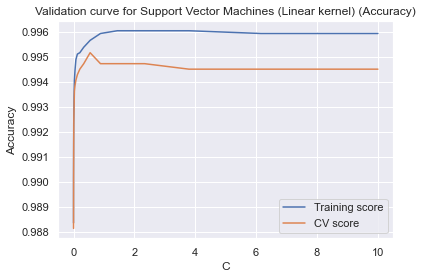

In [5]:
%%time
C_values = np.logspace(-3, 1, 20)
plot_curve(model=clf_lin,
           model_name='Support Vector Machines (Linear kernel)', 
           X=X_train, 
           y=y_train, 
           param_name='C',
           param_range=C_values, 
           scoring='accuracy', 
           curve_type='Validation')

CPU times: user 133 ms, sys: 14.2 ms, total: 147 ms
Wall time: 1.49 s


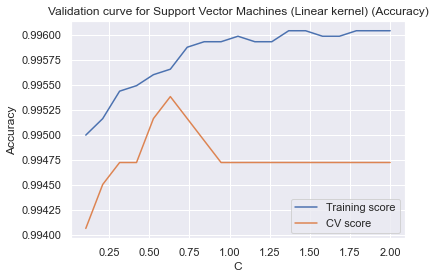

In [6]:
%%time
C_values = np.linspace(0, 2, 20)
plot_curve(model=clf_lin,
           model_name='Support Vector Machines (Linear kernel)', 
           X=X_train, 
           y=y_train, 
           param_name='C',
           param_range=C_values, 
           scoring='accuracy', 
           curve_type='Validation')

**Then, look at how well rbf kernel performs with different values of C.**

CPU times: user 133 ms, sys: 14.2 ms, total: 147 ms
Wall time: 6.7 s


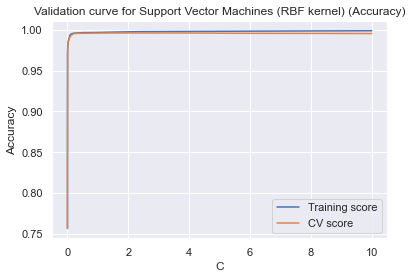

In [7]:
%%time
C_values = np.logspace(-3, 1, 20)
plot_curve(model=clf_rbf,
           model_name='Support Vector Machines (RBF kernel)', 
           X=X_train, 
           y=y_train, 
           param_name='C',
           param_range=C_values, 
           scoring='accuracy', 
           curve_type='Validation')

CPU times: user 143 ms, sys: 16.5 ms, total: 159 ms
Wall time: 2.76 s


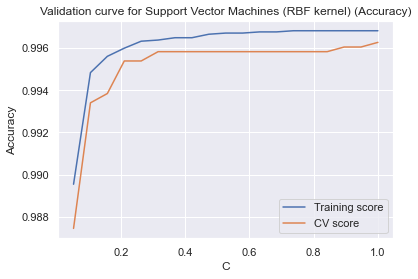

In [8]:
%%time
C_values = np.linspace(0, 1, 20)
plot_curve(model=clf_rbf,
           model_name='Support Vector Machines (RBF kernel)', 
           X=X_train, 
           y=y_train, 
           param_name='C',
           param_range=C_values, 
           scoring='accuracy', 
           curve_type='Validation')

**Now that we see that rbf kernel performs slightly better, we can run a grid search for the values of C.**

In [9]:
%%time
search_parameters = {'C':np.linspace(0.5,0.7,20)}
gs_clf = GridSearchCV(clf_rbf, search_parameters, cv=5, scoring='accuracy', n_jobs=-1)
gs_clf.fit(X_train, y_train)
print(gs_clf.best_params_)

{'C': 0.5}
CPU times: user 131 ms, sys: 12.8 ms, total: 143 ms
Wall time: 1.62 s


**So we train the "best" model.**

In [10]:
clf = SVC(kernel='rbf', C=0.5, random_state=2020)

In [11]:
%%time
clf.fit(X_train, y_train)

CPU times: user 45.2 ms, sys: 2.05 ms, total: 47.2 ms
Wall time: 47 ms


SVC(C=0.5, random_state=2020)

**Look at the learning curve.**

CPU times: user 580 ms, sys: 65 ms, total: 645 ms
Wall time: 6.93 s


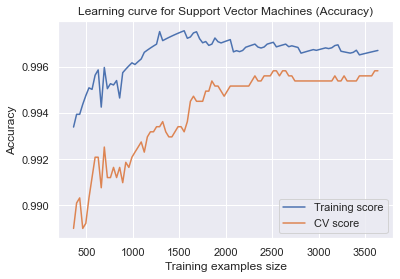

In [12]:
%%time
plot_curve(model=clf,
           model_name='Support Vector Machines', 
           X=X_train, 
           y=y_train, 
           param_name='Training examples size', 
           scoring='accuracy', 
           curve_type='Learning')

**And check test data.**

In [13]:
%%time
y_predicted = clf.predict(X_test)

CPU times: user 14 ms, sys: 1.14 ms, total: 15.2 ms
Wall time: 14.3 ms


In [14]:
print(classification_report(y_test, y_predicted, digits=4))

              precision    recall  f1-score   support

           0     0.9979    0.9837    0.9908       491
           1     0.9945    0.9993    0.9969      1459

    accuracy                         0.9954      1950
   macro avg     0.9962    0.9915    0.9938      1950
weighted avg     0.9954    0.9954    0.9954      1950



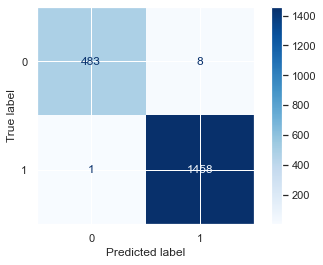

In [15]:
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, display_labels=[0,1]);

## Shill Bidding Dataset

In [16]:
df = pd.read_csv("Shill Bidding Dataset.csv")

X = df.drop(['Record_ID', 'Auction_ID', 'Bidder_ID', 'Class'], axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=2020) 

# Use MinMaxScaler because data has outliers, and we want to highlight those
scaler = MinMaxScaler() 

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns) 
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns) 

**Train SVMs with linear and rbf kernels and analyze them separately.**

In [17]:
clf_lin = SVC(kernel='linear', random_state=2020)
clf_rbf = SVC(kernel='rbf', random_state=2020)

clf_lin.fit(X_train, y_train)
clf_rbf.fit(X_train, y_train)

SVC(random_state=2020)

**First, see how well linear kernel performs with different values of C.**

CPU times: user 156 ms, sys: 16 ms, total: 172 ms
Wall time: 2.02 s


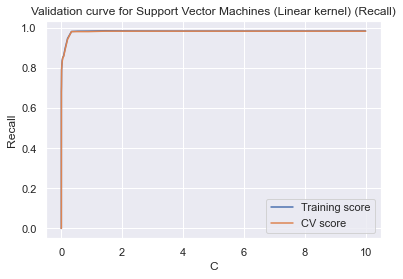

In [18]:
%%time
C_values = np.logspace(-3, 1, 20)
plot_curve(model=clf_lin,
           model_name='Support Vector Machines (Linear kernel)', 
           X=X_train, 
           y=y_train, 
           param_name='C',
           param_range=C_values, 
           scoring='recall', 
           curve_type='Validation')

CPU times: user 154 ms, sys: 15.1 ms, total: 170 ms
Wall time: 1.43 s


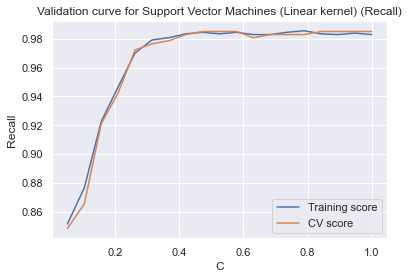

In [19]:
%%time
C_values = np.linspace(0, 1, 20)
plot_curve(model=clf_lin,
           model_name='Support Vector Machines (Linear kernel)', 
           X=X_train, 
           y=y_train, 
           param_name='C',
           param_range=C_values, 
           scoring='recall', 
           curve_type='Validation')

CPU times: user 165 ms, sys: 16.9 ms, total: 182 ms
Wall time: 3.49 s


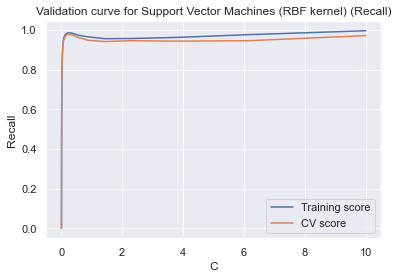

In [20]:
%%time
C_values = np.logspace(-3, 1, 20)
plot_curve(model=clf_rbf,
           model_name='Support Vector Machines (RBF kernel)', 
           X=X_train, 
           y=y_train, 
           param_name='C',
           param_range=C_values, 
           scoring='recall', 
           curve_type='Validation')

CPU times: user 151 ms, sys: 15 ms, total: 166 ms
Wall time: 2.05 s


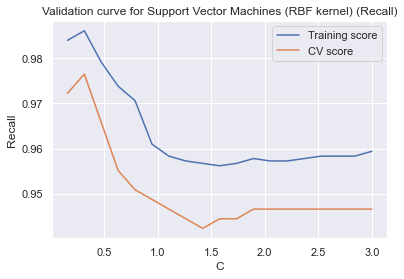

In [21]:
%%time
C_values = np.linspace(0, 3, 20)
plot_curve(model=clf_rbf,
           model_name='Support Vector Machines (RBF kernel)', 
           X=X_train, 
           y=y_train, 
           param_name='C',
           param_range=C_values, 
           scoring='recall', 
           curve_type='Validation')

**Run grid search with linear kernel and best range for C.**

In [22]:
%%time
search_parameters = {'C':np.linspace(0.4,0.6,20)}
gs_clf = GridSearchCV(clf_lin, search_parameters, cv=5, scoring='accuracy', n_jobs=-1)
gs_clf.fit(X_train, y_train)
print(gs_clf.best_params_)

{'C': 0.43157894736842106}
CPU times: user 112 ms, sys: 12.2 ms, total: 124 ms
Wall time: 821 ms


**Train the "best" model.**

In [23]:
clf = SVC(kernel='linear', C=0.43157894736842106, random_state=2020)

In [24]:
%%time
clf.fit(X_train, y_train)

CPU times: user 20.7 ms, sys: 1.2 ms, total: 21.9 ms
Wall time: 21.1 ms


SVC(C=0.43157894736842106, kernel='linear', random_state=2020)

**Plot the learning curve.**

CPU times: user 704 ms, sys: 84 ms, total: 788 ms
Wall time: 4.28 s


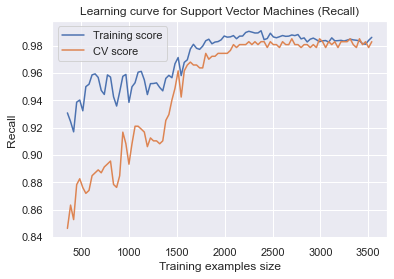

In [25]:
%%time
plot_curve(model=clf,
           model_name='Support Vector Machines', 
           X=X_train, 
           y=y_train, 
           param_name='Training examples size', 
           scoring='recall', 
           curve_type='Learning')

**Look at test data.**

In [26]:
%%time
y_predicted = clf.predict(X_test)

CPU times: user 6.7 ms, sys: 449 µs, total: 7.14 ms
Wall time: 6.79 ms


In [27]:
print(classification_report(y_test, y_predicted, digits=4))

              precision    recall  f1-score   support

           0     0.9994    0.9840    0.9917      1690
           1     0.8841    0.9952    0.9364       207

    accuracy                         0.9852      1897
   macro avg     0.9418    0.9896    0.9640      1897
weighted avg     0.9868    0.9852    0.9856      1897



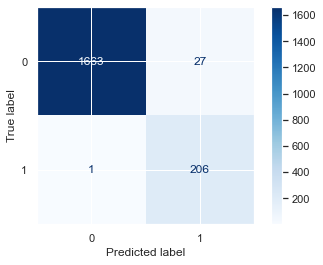

In [28]:
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, display_labels=[0,1]);